### **📝 Instructions**
Spam link detection system
We want to implement a system that is able to automatically detect whether a web page contains spam or not based on its URL.

In [36]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

import regex as re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

In [14]:
nltk.download('stopwords')
nltk.download("wordnet")
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...


#### **Step 1: Loading the dataset**
The dataset can be found in this project folder under the name url_spam.csv. You can load it into the code directly from the link:

`https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv`
Or download it and add it by hand in your repository.

In [3]:
df_raw = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv")
df_raw.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB


#### **Step 2: Preprocess the links**
Use what we have seen in this module to transform the data to make it compatible with the model we want to train. Segment the URLs into parts according to their punctuation marks, remove stopwords, lemmatize, and so on.

Make sure to conveniently split the dataset into train and test as we have seen in previous lessons.

In [24]:
# Transform the nun to cat
df = df_raw.copy()
df['is_spam'] = df['is_spam'].astype(int)
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


In [25]:
# Remove duplicates
df = df.drop_duplicates().reset_index(drop=True)
df.shape

(2369, 2)

In [26]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
is_spam,2369.0,0.102997,0.304019,0.0,0.0,0.0,0.0,1.0


In [27]:
print(f"Spam: {len(df.loc[df.is_spam == 1])}")
print(f"No spam: {len(df.loc[df.is_spam == 0])}")

Spam: 244
No spam: 2125


In [28]:
def preprocess_url(url):
    if url is None:
        return ''
    
    url = url.lower()
    url = re.sub(r'''[^a-z\s]''', ' ', url ) # Remove any character tha is not a letter a-z or white space
    url = re.sub(r'''\s+[a-zA-Z]\s+''', ' ', url) # Remove white spaces
    url = re.sub(r'''\^[a-zA-Z]\s+''', ' ', url) # Remove white spaces
    url = re.sub(r'''\s+''', ' ', url).strip() # Remove multiples white spaces
    url = re.sub('''&lt;/?.*?&gt''', ' &lt;&gt; ', url) # Remove tags

    tokens = url.split() # Tokenize the text
    # Lemmatize and filter tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token and token not in stop_words and len(token) > 3]

    return ' '.join(tokens).split()

#### **Explanation of the regular expression `&lt;/?.*?&gt;:`**
- `&lt;`: Represents the < symbol in HTML entity format.
- `/`: Indicates that a possible tag-closing character (as in `</tag>`) is being searched for.
- `?`: Makes the / character optional, that is, it matches both opening (`<tag>`) and closing (`</tag>`) tags.
- `.*?`: Is a pattern that matches any sequence of characters (dot `.` is any character except a newline, `*` means "zero or more times") non-greedily (`?`), making the match as short as possible.
- `&gt;`: Represents the > symbol in HTML entity format.

In [29]:
df['processed_url'] = df['url'].apply(preprocess_url)

df.head()

,url,is_spam,processed_url
0,https://briefingday.us8.list-manage.com/unsubs...,1,"[http, briefingday, list, manage, unsubscribe]"
1,https://www.hvper.com/,1,"[http, hvper]"
2,https://briefingday.com/m/v4n3i4f3,1,"[http, briefingday]"
3,https://briefingday.com/n/20200618/m#commentform,0,"[http, briefingday, commentform]"
4,https://briefingday.com/fan,1,"[http, briefingday]"


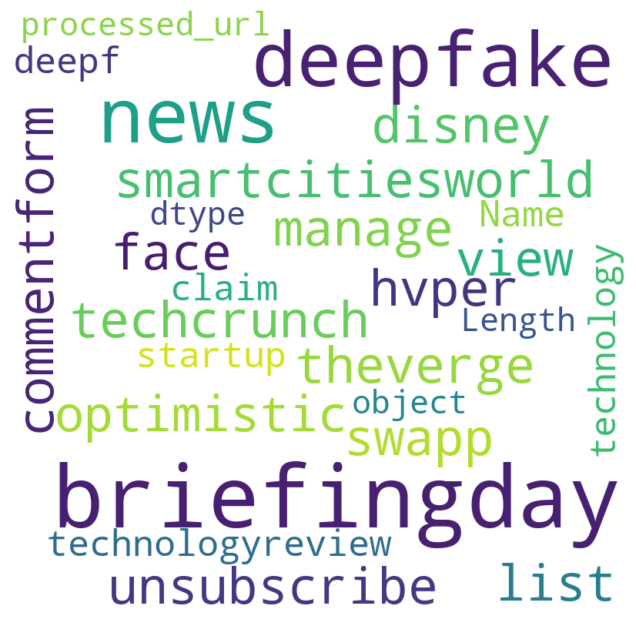

In [35]:
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=1000, min_font_size=20, random_state = 42).generate(str(df['processed_url']))

fig = plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Vectorize
X_interim = df['processed_url'].apply(lambda x: " ".join(x) if isinstance(x, list) else x)

vectorizer = TfidfVectorizer(max_features=5000, max_df=0.8, min_df=5)
X = vectorizer.fit_transform(X_interim).toarray()
y = df['is_spam']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### **Step 3: Build an SVM**
Start solving the problem by implementing an SVM with the default parameters. Train it and analyze its results.

In [42]:
model = SVC()
model.fit(X_train, y_train)

SVC()

In [43]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [44]:
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc}')

Accuracy: 0.9620253164556962


#### **Step 4: Optimize the previous model**
After training the SVM, optimize its hyperparameters using a grid search or a random search.

In [48]:
hyperparams = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree':[1, 2, 3]
}

grid_search = GridSearchCV(model, hyperparams, scoring='accuracy', cv=5)
grid_search

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'degree': [1, 2, 3],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='accuracy')

In [49]:
grid_search.fit(X_train, y_train)
print(f'Best hyperparams: {grid_search.best_params_}')

Best hyperparams: {'C': 1000, 'degree': 1, 'gamma': 'auto', 'kernel': 'poly'}


In [53]:
opt_model = SVC(C=1000, degree=1, gamma="auto", kernel="poly", random_state=42)
opt_model.fit(X_train, y_train)
y_pred_opt = opt_model.predict(X_test)
print(f'Accuracy Opt: {accuracy_score(y_test, y_pred_opt)}')

Accuracy Opt: 0.9556962025316456


#### **Step 5: Save the model**
Store the model in the corresponding folder.

In [56]:
import joblib

try:
    joblib.dump(opt_model, '../models/svc_C-1000_degree-1_gamma-auto_kernel-polu.joblib')
    print("The best model save")
except Exception as e:
    print("An error occurred", e)

The best model save
